In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque, defaultdict


In [2]:
GAMMA = 0.99
ACTOR_LR = 1e-5
CRITIC_LR = 1e-3
HIDDEN_SIZE = 64
MAX_STEPS = 500_000
EVAL_EVERY = 20_000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_SIZE),
            nn.Tanh(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.Tanh(),
            nn.Linear(HIDDEN_SIZE, action_dim)
        )

    def forward(self, x):
        # garantit [batch, state_dim]
        if x.dim() == 1:
            x = x.unsqueeze(0)
        logits = self.net(x)
        return torch.distributions.Categorical(logits=logits)


class Critic(nn.Module):
    def __init__(self, state_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, HIDDEN_SIZE),
            nn.Tanh(),
            nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE),
            nn.Tanh(),
            nn.Linear(HIDDEN_SIZE, 1)
        )

    def forward(self, x):
        if x.dim() == 1:
            x = x.unsqueeze(0)
        return self.net(x).squeeze(-1)


In [4]:
def compute_returns(rewards, next_value, terminated_flags, gamma):
    """
    Compute n-step returns with proper bootstrapping.
    
    Args:
        rewards: List of rewards (floats)
        next_value: Bootstrap value (tensor or 0 if terminated)
        terminated_flags: List of booleans indicating termination
        gamma: Discount factor
    
    Returns:
        Tensor of returns
    """
    returns = []
    
    # Ensure next_value is a scalar (0-dim tensor)
    if isinstance(next_value, torch.Tensor):
        if next_value.dim() > 0:
            G = next_value.squeeze().item()
        else:
            G = next_value.item()
    else:
        G = float(next_value)
    
    # Compute returns backwards
    for r, terminated in zip(reversed(rewards), reversed(terminated_flags)):
        if terminated:
            G = r
        else:
            G = r + gamma * G
        
        returns.insert(0, G)
    
    # Convert all to tensor at once
    return torch.tensor(returns, dtype=torch.float32, device=DEVICE)


In [5]:
def train_a2c(seed=0, K=1, n=1, reward_mask_prob=0.0, stochastic_reward=False):
    """
    Train A2C agent on CartPole.
    
    Args:
        seed: Random seed
        K: Number of parallel workers
        n: Number of steps for n-step returns
        reward_mask_prob: Probability of masking out rewards (0.9 for Agent 1)
        stochastic_reward: Add Gaussian noise to rewards
    """
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Initialize environments
    envs = [gym.make("CartPole-v1") for _ in range(K)]
    state_dim = envs[0].observation_space.shape[0]
    action_dim = envs[0].action_space.n

    # Initialize networks
    actor = Actor(state_dim, action_dim).to(DEVICE)
    critic = Critic(state_dim).to(DEVICE)
    actor_opt = optim.Adam(actor.parameters(), lr=ACTOR_LR)
    critic_opt = optim.Adam(critic.parameters(), lr=CRITIC_LR)

    # Buffers for each worker
    log_probs_buffer = [[] for _ in range(K)]
    values_buffer = [[] for _ in range(K)]
    rewards_buffer = [[] for _ in range(K)]
    terminated_buffer = [[] for _ in range(K)]
    truncated_buffer = [[] for _ in range(K)]

    # Initialize states
    states = [env.reset(seed=seed + i)[0] for i, env in enumerate(envs)]
    total_steps = 0
    episode_returns = [0.0 for _ in range(K)]
    
    # Logging
    all_returns = []
    recent_returns = []
    recent_actor_losses = []
    recent_critic_losses = []

    while total_steps < MAX_STEPS:
        # Collect n steps from K workers
        for step in range(n):
            actions = []
            log_probs_list = []
            values_list = []

            # Choose actions for all K environments
            for i in range(K):
                state_tensor = torch.tensor(states[i], dtype=torch.float32).to(DEVICE)
                dist = actor(state_tensor)
                action = dist.sample()
                log_prob = dist.log_prob(action)
                value = critic(state_tensor)

                actions.append(action.item())
                log_probs_list.append(log_prob)
                values_list.append(value)

            # Step all environments
            next_states = []
            for i, env in enumerate(envs):
                next_state, reward, terminated, truncated, _ = env.step(actions[i])
                
                # Track actual reward for logging (BEFORE masking)
                episode_returns[i] += reward
                
                # Apply reward modifications for learning
                reward_for_learning = reward
                
                # Option 1: Apply reward masking (Agent 1)
                if reward_mask_prob > 0:
                    if np.random.random() < reward_mask_prob:
                        reward_for_learning = 0.0
                
                # Option 2: Add stochastic noise
                if stochastic_reward:
                    reward_for_learning += np.random.normal(0, 0.1)
                
                # Store transition avec la récompense masquée
                log_probs_buffer[i].append(log_probs_list[i])
                values_buffer[i].append(values_list[i])
                rewards_buffer[i].append(reward_for_learning)  # Récompense masquée
                terminated_buffer[i].append(terminated)
                truncated_buffer[i].append(truncated)
                
                # Handle episode end
                done = terminated or truncated
                if done:
                    all_returns.append(episode_returns[i])
                    recent_returns.append(episode_returns[i])
                    if len(recent_returns) > 20:
                        recent_returns.pop(0)
                    episode_returns[i] = 0.0
                    next_state = env.reset()[0]
                
                next_states.append(next_state)

            states = next_states
            total_steps += K

        # Update networks after collecting n steps from K workers
        actor_losses = []
        critic_losses = []
        
        for i in range(K):
            if len(rewards_buffer[i]) == 0:
                continue
                
            # Compute bootstrap value
            with torch.no_grad():
                state_tensor = torch.tensor(states[i], dtype=torch.float32).to(DEVICE)
                next_value = critic(state_tensor)
                
                # CRITICAL: Don't bootstrap if episode terminated (pole fell)
                # But DO bootstrap if truncated (time limit reached)
                if terminated_buffer[i][-1]:
                    next_value = torch.tensor(0.0, device=DEVICE)
            
            # Compute n-step returns using helper function
            returns = compute_returns(
                rewards_buffer[i],
                next_value,
                terminated_buffer[i],
                GAMMA
            )
            values_t = torch.stack(values_buffer[i])
            log_probs_t = torch.stack(log_probs_buffer[i])
            
            # Compute advantages
            advantages = returns - values_t
            
            # Actor loss (policy gradient)
            actor_loss = -(log_probs_t * advantages.detach()).mean()
            
            # Critic loss (value function)
            critic_loss = advantages.pow(2).mean()
            
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
            
            # Clear buffers for this worker
            log_probs_buffer[i].clear()
            values_buffer[i].clear()
            rewards_buffer[i].clear()
            terminated_buffer[i].clear()
            truncated_buffer[i].clear()
        
        # Average losses across workers and update
        if len(actor_losses) > 0:
            avg_actor_loss = torch.stack(actor_losses).mean()
            avg_critic_loss = torch.stack(critic_losses).mean()
            
            actor_opt.zero_grad()
            avg_actor_loss.backward()
            actor_opt.step()
            
            critic_opt.zero_grad()
            avg_critic_loss.backward()
            critic_opt.step()
            
            # Log losses
            recent_actor_losses.append(avg_actor_loss.item())
            recent_critic_losses.append(avg_critic_loss.item())

        # AFFICHAGE LIVE TOUTES LES 1000 STEPS
        if total_steps % 1000 == 0 and len(recent_returns) > 0:
            avg_ret = np.mean(recent_returns)
            avg_act = np.mean(recent_actor_losses[-50:]) if len(recent_actor_losses) >= 1 else 0.0
            avg_crit = np.mean(recent_critic_losses[-50:]) if len(recent_critic_losses) >= 1 else 0.0
            print(
                f"[seed={seed}] steps={total_steps:6d} | "
                f"avg_return(last_20_ep)={avg_ret:6.1f} | "
                f"actor_loss={avg_act:.3e} | "
                f"critic_loss={avg_crit:.3e}"
            )

    # Cleanup
    for env in envs:
        env.close()

    return all_returns


In [6]:
def plot_comparison(all_agents_results, save_path=None):
    """
    Create comprehensive comparison plots for all agents (multi-seed).
    
    Args:
        all_agents_results: dict
            key   -> agent name
            value -> list of lists (one return list per seed)
        save_path: optional path to save the figure
    """

    import numpy as np
    import matplotlib.pyplot as plt

    # -------------------------------------------------------------------------
    # Helper: aggregate multiple seeds
    # -------------------------------------------------------------------------
    def aggregate_seeds(seed_runs):
        min_len = min(len(r) for r in seed_runs)
        trimmed = np.array([r[:min_len] for r in seed_runs])
        return trimmed.mean(axis=0), trimmed.std(axis=0)

    # -------------------------------------------------------------------------
    # Figure setup
    # -------------------------------------------------------------------------
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

    # =========================================================================
    # PLOT 1: Learning curves (moving average, mean ± std)
    # =========================================================================
    ax = axes[0, 0]

    for idx, (agent_name, seed_runs) in enumerate(all_agents_results.items()):
        mean_r, std_r = aggregate_seeds(seed_runs)

        if len(mean_r) >= 20:
            window = 20
            ma_mean = np.convolve(mean_r, np.ones(window)/window, mode='valid')
            ma_std  = np.convolve(std_r,  np.ones(window)/window, mode='valid')
            episodes = np.arange(len(ma_mean))

            ax.plot(
                episodes, ma_mean,
                label=agent_name,
                color=colors[idx],
                linewidth=2
            )
            ax.fill_between(
                episodes,
                ma_mean - ma_std,
                ma_mean + ma_std,
                color=colors[idx],
                alpha=0.2
            )

    ax.axhline(500, linestyle='--', linewidth=2, alpha=0.5, label='Optimal (500)')
    ax.set_xlabel('Episode')
    ax.set_ylabel('Return (20-episode moving avg)')
    ax.set_title('Learning Curves (Mean ± Std over seeds)', fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

    # =========================================================================
    # PLOT 2: Final performance (last 50 episodes)
    # =========================================================================
    ax = axes[0, 1]
    agent_names, final_means, final_stds = [], [], []

    for agent_name, seed_runs in all_agents_results.items():
        mean_r, std_r = aggregate_seeds(seed_runs)
        last_50 = mean_r[-50:] if len(mean_r) >= 50 else mean_r

        agent_names.append(agent_name)
        final_means.append(np.mean(last_50))
        final_stds.append(np.std(last_50))

    x = np.arange(len(agent_names))
    bars = ax.bar(
        x, final_means, yerr=final_stds,
        capsize=5, alpha=0.75,
        edgecolor='black',
        linewidth=1.5,
        color=colors[:len(agent_names)]
    )

    ax.axhline(500, linestyle='--', linewidth=2, alpha=0.5)
    ax.set_ylabel('Average Return')
    ax.set_title('Final Performance (Last 50 Episodes)', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(agent_names, rotation=15, ha='right', fontsize=9)
    ax.grid(True, axis='y', alpha=0.3)

    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h,
                f'{h:.1f}', ha='center', va='bottom', fontsize=9)

    # =========================================================================
    # PLOT 3: Learning speed (episodes to reach threshold)
    # =========================================================================
    ax = axes[1, 0]
    threshold = 400
    episodes_to_threshold = []

    for agent_name, seed_runs in all_agents_results.items():
        mean_r, _ = aggregate_seeds(seed_runs)

        if len(mean_r) >= 20:
            ma = np.convolve(mean_r, np.ones(20)/20, mode='valid')
            reached = np.where(ma >= threshold)[0]
            episodes_to_threshold.append(
                reached[0] if len(reached) > 0 else len(ma)
            )
        else:
            episodes_to_threshold.append(len(mean_r))

    y = np.arange(len(agent_names))
    bars = ax.barh(
        y, episodes_to_threshold,
        alpha=0.75,
        edgecolor='black',
        linewidth=1.5,
        color=colors[:len(agent_names)]
    )

    ax.set_yticks(y)
    ax.set_yticklabels(agent_names, fontsize=9)
    ax.set_xlabel('Episodes to reach avg return = 400')
    ax.set_title('Learning Speed', fontweight='bold')
    ax.grid(True, axis='x', alpha=0.3)

    for i, bar in enumerate(bars):
        w = bar.get_width()
        ax.text(w + 5, bar.get_y() + bar.get_height()/2,
                f'{int(w)}', va='center', fontsize=9)

    # =========================================================================
    # PLOT 4: Stability (inter-seed variance)
    # =========================================================================
    ax = axes[1, 1]
    stability = []

    for agent_name, seed_runs in all_agents_results.items():
        _, std_r = aggregate_seeds(seed_runs)
        last_100 = std_r[-100:] if len(std_r) >= 100 else std_r
        stability.append(np.mean(last_100))

    x = np.arange(len(agent_names))
    bars = ax.bar(
        x, stability,
        alpha=0.75,
        edgecolor='black',
        linewidth=1.5,
        color=colors[:len(agent_names)]
    )

    ax.set_ylabel('Std Dev across seeds')
    ax.set_title('Learning Stability (Last 100 Episodes)', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(agent_names, rotation=15, ha='right', fontsize=9)
    ax.grid(True, axis='y', alpha=0.3)

    for bar in bars:
        h = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, h,
                f'{h:.2f}', ha='center', va='bottom', fontsize=9)

    # -------------------------------------------------------------------------
    # Finalize
    # -------------------------------------------------------------------------
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"\nFigure saved to: {save_path}")

    plt.show()

    # -------------------------------------------------------------------------
    # Summary statistics
    # -------------------------------------------------------------------------
    print("\n" + "="*80)
    print("SUMMARY STATISTICS (Mean ± Std across seeds)")
    print("="*80)

    for agent_name, seed_runs in all_agents_results.items():
        mean_r, std_r = aggregate_seeds(seed_runs)
        print(f"\n{agent_name}:")
        print(f"  Final return      : {mean_r[-1]:.1f} ± {std_r[-1]:.1f}")
        print(f"  Max mean return   : {mean_r.max():.1f}")
        print(f"  Total episodes    : {len(mean_r)}")


In [7]:
SEEDS = [0, 1, 2]

all_results = {}

def run_agent(name, **kwargs):
    runs = []
    for seed in SEEDS:
        print(f"\n{name} | seed={seed}")
        returns = train_a2c(seed=seed, **kwargs)
        runs.append(returns)
    return runs


In [8]:
print("="*70)
print("ENTRAÎNEMENT DES 5 AGENTS A2C SUR CARTPOLE (SEEDS 0,1,2)")
print("="*70)

all_results["Agent 0 (K=1,n=1)"] = run_agent(
    "Agent 0",
    K=1, n=1,
    reward_mask_prob=0.0,
    stochastic_reward=False
)

all_results["Agent 1 (90% mask)"] = run_agent(
    "Agent 1",
    K=1, n=1,
    reward_mask_prob=0.9,
    stochastic_reward=True
)

all_results["Agent 2 (K=6,n=1)"] = run_agent(
    "Agent 2",
    K=6, n=1,
    reward_mask_prob=0.9,
    stochastic_reward=False
)

all_results["Agent 3 (K=1,n=6)"] = run_agent(
    "Agent 3",
    K=1, n=6,
    reward_mask_prob=0.9,
    stochastic_reward=False
)

all_results["Agent 4 (K=6,n=6)"] = run_agent(
    "Agent 4",
    K=6, n=6,
    reward_mask_prob=0.9,
    stochastic_reward=False
)


ENTRAÎNEMENT DES 5 AGENTS A2C SUR CARTPOLE (SEEDS 0,1,2)

Agent 0 | seed=0
[seed=0] steps=  1000 | avg_return(last_20_ep)=  22.8 | actor_loss=-1.160e-01 | critic_loss=1.350e+01
[seed=0] steps=  2000 | avg_return(last_20_ep)=  24.9 | actor_loss=2.290e-01 | critic_loss=8.350e+00
[seed=0] steps=  3000 | avg_return(last_20_ep)=  30.0 | actor_loss=-1.504e-01 | critic_loss=6.827e+00
[seed=0] steps=  4000 | avg_return(last_20_ep)=  33.4 | actor_loss=-5.071e-01 | critic_loss=8.167e+00
[seed=0] steps=  5000 | avg_return(last_20_ep)=  35.9 | actor_loss=-3.610e-01 | critic_loss=6.712e+00
[seed=0] steps=  6000 | avg_return(last_20_ep)=  44.0 | actor_loss=3.732e-01 | critic_loss=2.672e+00
[seed=0] steps=  7000 | avg_return(last_20_ep)=  52.6 | actor_loss=-4.739e-01 | critic_loss=4.024e+00
[seed=0] steps=  8000 | avg_return(last_20_ep)=  59.9 | actor_loss=-3.942e-01 | critic_loss=6.241e+00
[seed=0] steps=  9000 | avg_return(last_20_ep)=  55.3 | actor_loss=-1.865e-01 | critic_loss=1.224e+01
[seed=0] 

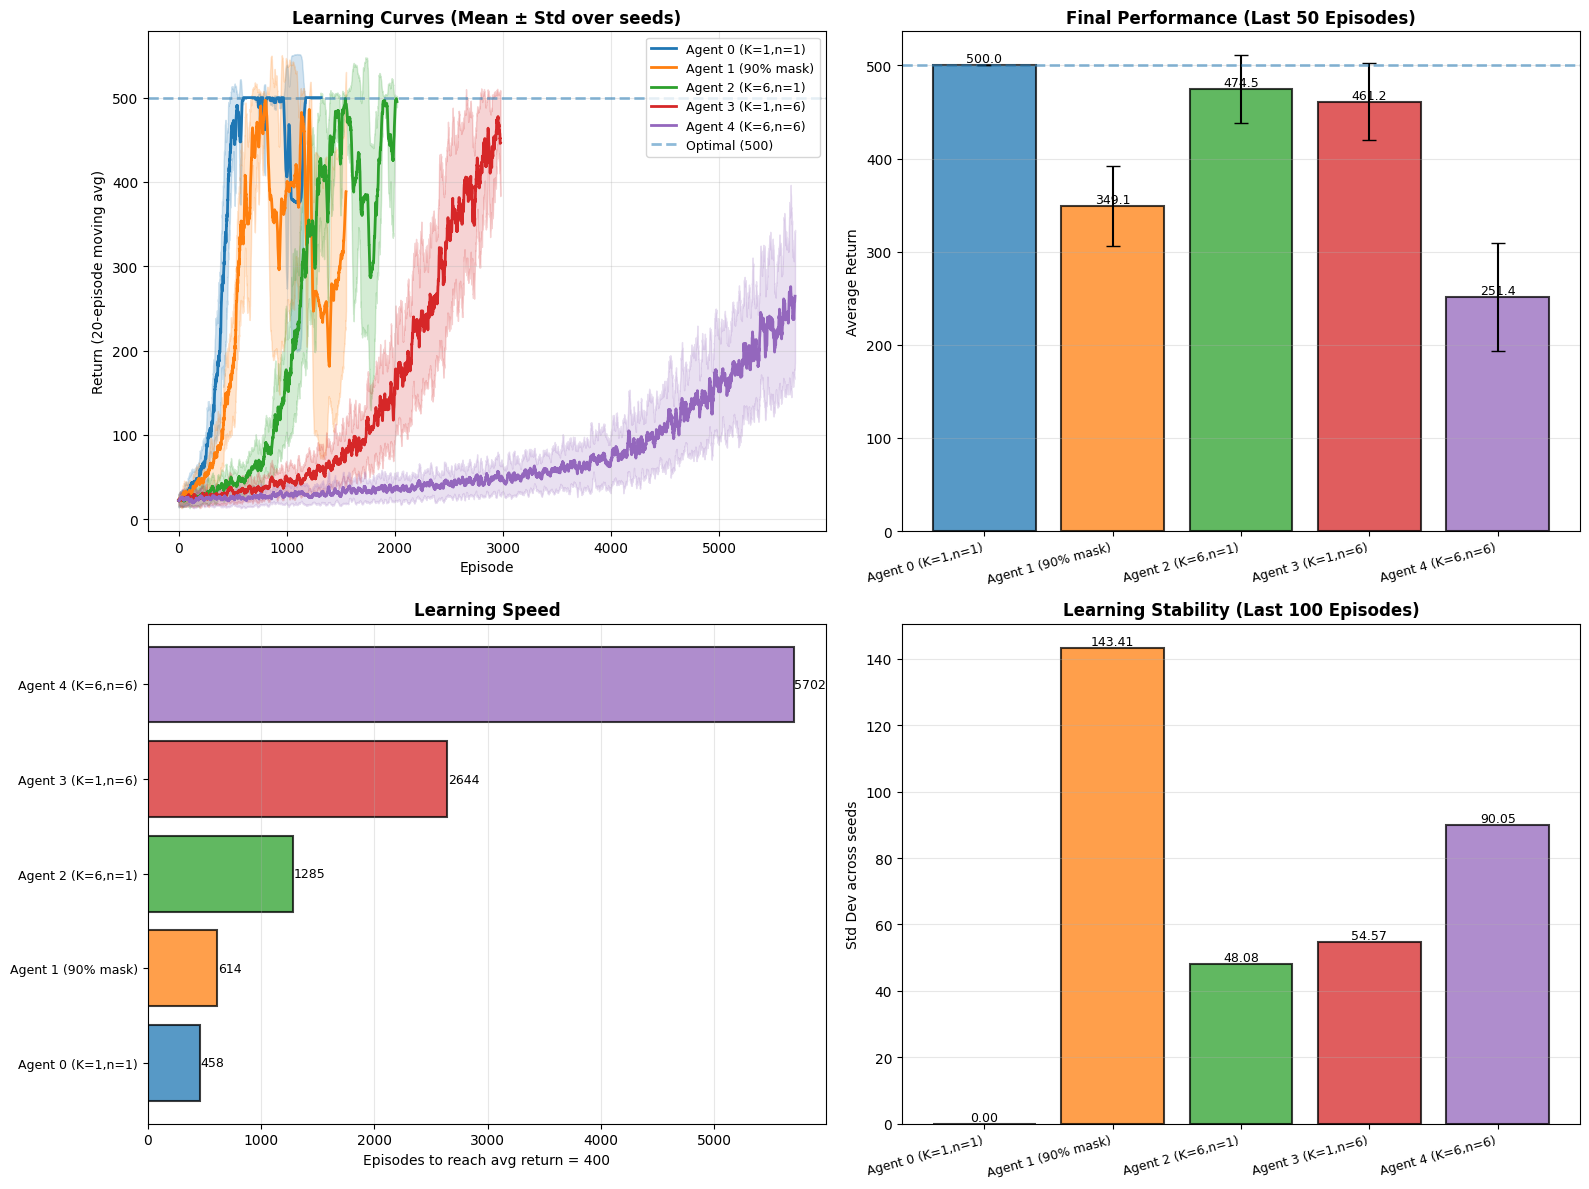


SUMMARY STATISTICS (Mean ± Std across seeds)

Agent 0 (K=1,n=1):
  Final return      : 500.0 ± 0.0
  Max mean return   : 500.0
  Total episodes    : 1338

Agent 1 (90% mask):
  Final return      : 344.7 ± 159.1
  Max mean return   : 500.0
  Total episodes    : 1568

Agent 2 (K=6,n=1):
  Final return      : 500.0 ± 0.0
  Max mean return   : 500.0
  Total episodes    : 2039

Agent 3 (K=1,n=6):
  Final return      : 500.0 ± 0.0
  Max mean return   : 500.0
  Total episodes    : 2996

Agent 4 (K=6,n=6):
  Final return      : 227.7 ± 129.2
  Max mean return   : 384.3
  Total episodes    : 5721


In [9]:
plot_comparison(all_results)

In [ ]:
import os
import torch

def save_agent(actor, agent_name):
    os.makedirs("models", exist_ok=True)
    path = f"models/{agent_name}.pt"
    torch.save(actor.state_dict(), path)
    print(f"✅ Agent sauvegardé : {path}")

save_agent(actor, agent_name)

